In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import networkx as nx
import pandas as pd
import tarfile
import requests
from io import BytesIO

def load_librec_filmtrust_trust():
    url = 'http://konect.cc/files/download.tsv.librec-filmtrust-trust.tar.bz2'
    extract_filename = 'librec-filmtrust-trust/out.librec-filmtrust-trust'
    response = requests.get(url)
    tar_file = BytesIO(response.content)

    with tarfile.open(fileobj=tar_file, mode="r:bz2") as tar:
        extracted_file = tar.extractfile(extract_filename)
        df = pd.read_csv(extracted_file, comment='%', delimiter='\t', header=None, names=['src', 'dst'])

    G = nx.from_pandas_edgelist(df, 'src', 'dst', create_using=nx.DiGraph())
    return G

G = load_librec_filmtrust_trust()
print(G)

DiGraph with 874 nodes and 1853 edges


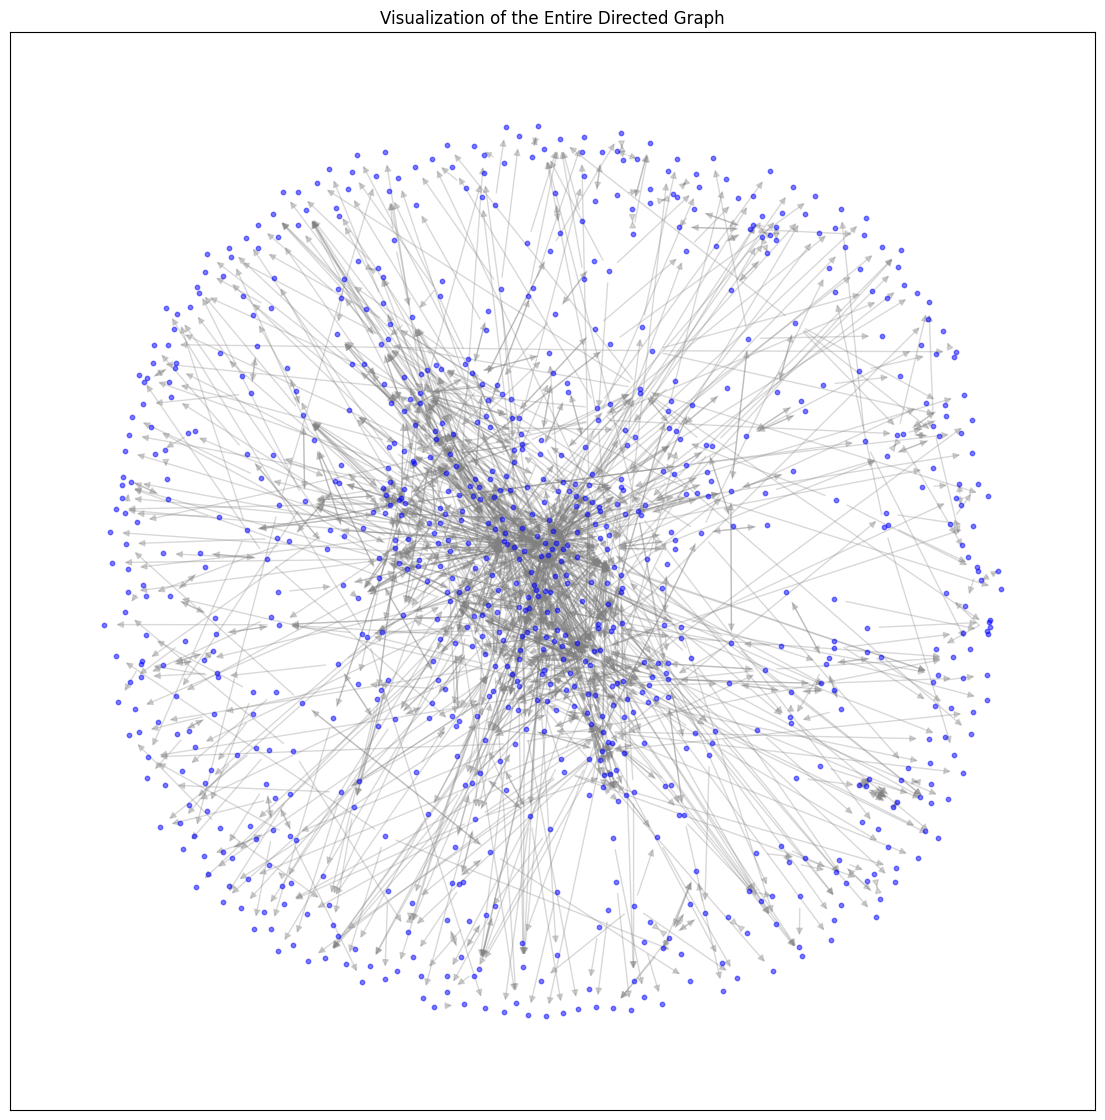

In [3]:
import networkx as nx
import matplotlib.pyplot as plt

# Function to draw the entire graph
def draw_entire_graph(G, node_size=10, node_color='blue', node_alpha=0.5, edge_color='gray', edge_alpha=0.3):
    plt.figure(figsize=(14, 14))  # Increase the figure size for better visibility
    pos = nx.spring_layout(G, k=0.1)  # k controls the distance between nodes
    nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color, alpha=node_alpha)
    nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=10, edge_color=edge_color, alpha=edge_alpha)
    plt.title("Visualization of the Entire Directed Graph")
    plt.show()

# Draw the entire graph
draw_entire_graph(G)


In [4]:
from scipy.sparse.linalg import eigs
import numpy as np

from randcolorgraphs.utils.calculate_katz import calculate_katz

def get_adj_and_katz(G, alpha=0.1, beta=1.0):
    A_G = nx.adjacency_matrix(G).astype(np.float64)

    eigenvalues, _ = eigs(A_G, k=1, which='LM')  # 'LM': Largest Magnitude, tol is tolerance
    spectral_radius_G = np.abs(eigenvalues).max()
    print(f"Spectral Radius: {spectral_radius_G}, alpha_max = {1/spectral_radius_G}")
    print("calculating katz centrality")
    katz_centrality = calculate_katz(A_G, alpha = alpha, beta=beta)
    print("done calculating katz")

    # Reorder nodes based on Katz centrality
    sorted_indices = np.argsort(katz_centrality)
    sorted_nodes = np.array(G.nodes())[sorted_indices]

    # Generate the adjacency matrix
    adj_matrix = nx.adjacency_matrix(G, nodelist=sorted_nodes)

    sorted_katz_vector = katz_centrality[sorted_indices]

    assert np.allclose(sorted_katz_vector, calculate_katz(adj_matrix.astype(np.float64), alpha = alpha, beta=beta))
    return adj_matrix, sorted_katz_vector

In [5]:
A_G, katz_centrality = get_adj_and_katz(G, alpha = 0.06)
A_G_dense = A_G.todense()

print("katz vector mean and max", np.mean(katz_centrality), np.max(katz_centrality))

Spectral Radius: 11.66806170409366, alpha_max = 0.08570403768512441
calculating katz centrality
Katz converged after 84 iterations.
done calculating katz
Katz converged after 84 iterations.
katz vector mean and max 1.3004673365076846 9.97636617173303


In [6]:
import kmeans1d

from randcolorgraphs.objectives.get_cluster_loss_ell_sqr import get_cluster_loss_ell_sqr
from randcolorgraphs.objectives.get_expected_edgeoverlap import get_expected_edgeoverlap
from randcolorgraphs.algorithms.linear_scalarization.optimal_contiguous.optimal_contiguous_linear_scalarization_algo import optimal_contiguous_linear_scalarization_algo


from fast_pareto import is_pareto_front

def evaluate_cluster_assignment(katz_centrality, A, clusters):
    ell_sqr = get_cluster_loss_ell_sqr(katz_centrality, clusters)
    expected_edge_overlap = get_expected_edgeoverlap(A, clusters)
    return [ell_sqr, expected_edge_overlap]

### Analyze all possible clusters for their performance regarding specific merics and booleans
df = pd.DataFrame(columns=["ell_sqr", "expected_edge_overlap", "method_type"])

for k in range(1, 30, 1):
    colors, _ = kmeans1d.cluster(katz_centrality, k)
    clusters = np.array(colors)
    df.loc[len(df)] = evaluate_cluster_assignment(katz_centrality, A_G, clusters) + [f"Kmeans1d (k={k}) on Katz centrality"]

for k in range(35, 800, 10):
    colors, _ = kmeans1d.cluster(katz_centrality, k)
    clusters = np.array(colors)
    df.loc[len(df)] = evaluate_cluster_assignment(katz_centrality, A_G, clusters) + [f"Kmeans1d (k={k}) on Katz centrality"]

In [7]:
for w in np.exp(-np.linspace(-1,12,50)):
    clusters = optimal_contiguous_linear_scalarization_algo(katz_centrality, A_G_dense, w)
    print(f"Done w={w}")
    df.loc[len(df)] = evaluate_cluster_assignment(katz_centrality, A_G, clusters) + [f"Opt. Cont. Scal. (w={w})"]


Done w=2.718281828459045
Done w=2.0848436773564623
Done w=1.5990149047485729
Done w=1.2263982635139905
Done w=0.9406120582638513
Done w=0.721422290354756
Done w=0.5533100670443569
Done w=0.42437284567694994
Done w=0.32548171969825196
Done w=0.24963508136045084
Done w=0.19146289967870536
Done w=0.14684651593678472
Done w=0.11262703781755547
Done w=0.08638168612061391
Done w=0.06625225915226167
Done w=0.05081356986537189
Done w=0.03897254094428699
Done w=0.029890813648367348
Done w=0.022925391029511424
Done w=0.017583112993804707
Done w=0.013485739988247985
Done w=0.010343173196618241
Done w=0.007932915202908387
Done w=0.006084316913218732
Done w=0.004666495399687063
Done w=0.003579067235631623
Done w=0.002745041231162644
Done w=0.002105367366604703
Done w=0.0016147559818205847
Done w=0.001238471215135408
Done w=0.0009498716635746116
Done w=0.000728524140275115
Done w=0.0005587569808812448
Done w=0.00042855047132085846
Done w=0.00032868583794635955
Done w=0.0002520925475441013
Done w=0.0

In [8]:
from greedy_algo_fast import greedy_search
import scipy.sparse as sp

def get_edge_vector_from_adj_matrix(adj_matrix):
    sparse_matrix = sp.csr_matrix(adj_matrix)
    row_indices, col_indices = sparse_matrix.nonzero()
    edge_vector = np.vstack((row_indices, col_indices)).T
    return edge_vector

edges = get_edge_vector_from_adj_matrix(A_G)

for w in np.exp(-np.linspace(-1,12,50)):
    clusters, _ = greedy_search(katz_centrality, edges, np.array([0]*len(katz_centrality)), w=w, max_interaction_dist=5)
    print(f"Done w={w}")
    df.loc[len(df)] = evaluate_cluster_assignment(katz_centrality, A_G, clusters) + [f"Greedy Search (w={w})"]

Iteration 0 Objective: 412.82685827372893 move_type split expected_edge_overlap 70.93039588458959
Iteration 1 Objective: 409.18539787848954 move_type split expected_edge_overlap 74.65521306728365
Iteration 2 Objective: 407.2792605105381 move_type swap expected_edge_overlap 73.36791053488164
Iteration 3 Objective: 405.4066251553365 move_type swap expected_edge_overlap 73.00703763602846
Iteration 4 Objective: 403.7045235347943 move_type swap expected_edge_overlap 72.04322212730705
Iteration 5 Objective: 402.1637212873503 move_type swap expected_edge_overlap 70.596698643647
Iteration 6 Objective: 400.58734387173456 move_type swap expected_edge_overlap 70.16020381548552
Iteration 7 Objective: 399.02612124392516 move_type swap expected_edge_overlap 69.6617760252792
Iteration 8 Objective: 397.47265013602816 move_type swap expected_edge_overlap 69.09084607982342
Iteration 9 Objective: 396.3251944380876 move_type swap expected_edge_overlap 69.02865739893909
Iteration 10 Objective: 395.25277664

In [9]:
from utils.colour_refinement_out_neigh_algorithm import colour_refinement_out_neigh_algorithm

for d in range(7):
    clusters = colour_refinement_out_neigh_algorithm(A_G, d)
    print(f"Done depth {d}")
    df.loc[len(df)] = evaluate_cluster_assignment(katz_centrality, A_G, clusters) + [f"Out-NeSt Model (d={d})"]


Done depth 0
Done depth 1
Done depth 2
Done depth 3
Done depth 4
Done depth 5
Converged at depth 5 with 389 unique clusters
Done depth 6


In [10]:

dfplot = df.copy()
dfplot["is_pareto_front"] = is_pareto_front(df[['ell_sqr', 'expected_edge_overlap']].values)

In [11]:
import pandas as pd
import plotly.express as px

def get_method_type_name(method_type):
    if 'Kmeans' in method_type:
        return 'Kmeans'
    elif 'Greedy Search' in method_type:
        return 'Greedy Search'
    elif 'Opt. Cont. Scal.' in method_type:
        return 'Opt. Cont. Scal.'
    elif 'Out-NeSt Model' in method_type:
        return 'Out-NeSt Model'
    else:
        return 'Other'

dfplot['method_type_name'] = dfplot['method_type'].apply(get_method_type_name)
dfplot['(Expected Edge Overlap)/|E|'] = dfplot['expected_edge_overlap'] / G.number_of_edges()

# Determining shape based on is_pareto_front
dfplot['shape'] = dfplot['is_pareto_front'].apply(lambda x: 'circle-open' if x else 'square-open')

# Plotting with Plotly
fig = px.scatter(
    dfplot,
    x='ell_sqr',
    y='(Expected Edge Overlap)/|E|',
    hover_data=['method_type'],
    symbol='shape',
    color='method_type_name',
    symbol_sequence=['circle-open', 'square-open']
)

fig.update_traces(marker=dict(size=10, line=dict(width=2)))

# Updating layout for legend
fig.update_layout(
    height=800,
    legend_title_text='Method Type',
    legend=dict(
        title='Method Type',
        itemsizing='constant',
        traceorder='normal',
        font=dict(size=10)
    )
)

fig.show()


In [14]:

fig.update_xaxes(type='log', tickformat=".0e")
fig.show()

In [13]:
unique_clusters, cluster_indices = np.unique(clusters, return_inverse=True)
H = np.identity(len(unique_clusters))[cluster_indices]

HtHinv = np.linalg.inv(H.T @ H)
Ppar = H @ HtHinv @ H.T

edge_probs = A @ Ppar

NameError: name 'A' is not defined

Arguments:
- privacy for 
- reidentification in large graphs i.e. n=1_000_000 through the degree is not as trivial